# COVID-19 U.S. State-level and City-level Trends

In [1]:
%matplotlib inline

import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker


# Plot configurations
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.2})
sns.set_style("darkgrid")
custom_style = {
            'grid.color': '0.8',
            'grid.linestyle': '--',
            'grid.linewidth': 0.5,
}
sns.set_style(custom_style)

### Run Parameters

In [2]:
# Path to input csvs
DATA_DIR = "csse_covid_19_daily_reports/"

# Date range to cover
MIN_DATE = "2020-03-18"
MAX_DATE = "2020-05-05"

# Add these back after rank filtering
STATE_INCLUDE_LIST = []
CITY_INCLUDE_LIST = []

# Exclude globally
STATE_EXCLUDE_LIST = []
CITY_EXCLUDE_LIST = []

# Manually set states or cities globally
STATE_OVERRIDE_LIST = []
CITY_OVERRIDE_LIST = []

# Limit to top n on max input date
CITY_LIMIT = 0
STATE_LIMIT = 5

### Sample Input Data

In [3]:
# Data sample pre-3/22

pd.read_csv(DATA_DIR + "03-21-2020.csv").head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-21T10:13:08,67800,3139,58946,30.9756,112.2707
1,NaN,Italy,2020-03-21T17:43:03,53578,4825,6072,41.8719,12.5674
2,NaN,Spain,2020-03-21T13:13:30,25374,1375,2125,40.4637,-3.7492
3,NaN,Germany,2020-03-21T20:43:02,22213,84,233,51.1657,10.4515
4,NaN,Iran,2020-03-21T11:13:12,20610,1556,7635,32.4279,53.6880


In [4]:
# Data sample post-3/22

pd.read_csv(DATA_DIR + "03-22-2020.csv").head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,36061.0,New York City,New York,US,3/22/20 23:45,40.767273,-73.971526,9654,63,0,0,"New York City, New York, US"
1,36059.0,Nassau,New York,US,3/22/20 23:45,40.740665,-73.589419,1900,4,0,0,"Nassau, New York, US"
2,36119.0,Westchester,New York,US,3/22/20 23:45,41.162784,-73.757417,1873,0,0,0,"Westchester, New York, US"
3,36103.0,Suffolk,New York,US,3/22/20 23:45,40.883201,-72.801217,1034,9,0,0,"Suffolk, New York, US"
4,36087.0,Rockland,New York,US,3/22/20 23:45,41.150279,-74.025605,455,1,0,0,"Rockland, New York, US"


### Data Loading and Transormation

In [5]:
def build_aggregate_df():

    agg_df = None

    for fn in glob.glob(DATA_DIR + "*.csv"):
        df = pd.read_csv(fn)
        df["Date"] = fn.split("/")[-1].split(".csv")[0]
        df.rename(columns={
            "Country/Region": "Country_Region", 
            "Province/State": "Province_State",
            "Lat": "Latitude",
            "Long_": "Longitude",
            "Last Update": "Last_Update",
            "Admin2": "City"
        }, inplace=True)
        if agg_df is None:
            agg_df = df
        else:
            agg_df = agg_df.append(df, ignore_index=True)

    agg_df["Date"] = pd.to_datetime(agg_df["Date"])
    
    # Limit date range
    agg_df = agg_df[agg_df["Date"].between(MIN_DATE, MAX_DATE)]
    
    # Filter for U.S. only
    agg_df = agg_df[agg_df["Country_Region"]=="US"]
    
    # Filter exclusion lists
    agg_df = agg_df[~agg_df.Province_State.isin(STATE_EXCLUDE_LIST)]
    agg_df = agg_df[~agg_df.City.isin(CITY_EXCLUDE_LIST)]
    
    if STATE_OVERRIDE_LIST:
        agg_df = agg_df[agg_df.Province_State.isin(STATE_OVERRIDE_LIST)]
        
    if CITY_OVERRIDE_LIST:
        agg_df = agg_df[agg_df.City.isin(CITY_OVERRIDE_LIST)]

    print("Num Rows:", agg_df.shape[0])
    print("Total Dates:", agg_df["Date"].unique().shape[0])
    print("Min Date:", agg_df["Date"].min())
    print("Max Date:", agg_df["Date"].max())
    
    return agg_df

agg_df = build_aggregate_df()

agg_df.head()

Num Rows: 127038
Total Dates: 49
Min Date: 2020-03-18 00:00:00
Max Date: 2020-05-05 00:00:00


,FIPS,City,Province_State,Country_Region,Last_Update,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Combined_Key,Date
0,45001.0,Abbeville,South Carolina,US,2020-03-23 23:19:34,34.223334,-82.461707,1.0,0.0,0.0,0.0,"Abbeville, South Carolina, US",2020-03-23
1,22001.0,Acadia,Louisiana,US,2020-03-23 23:19:34,30.295065,-92.414197,1.0,0.0,0.0,0.0,"Acadia, Louisiana, US",2020-03-23
2,51001.0,Accomack,Virginia,US,2020-03-23 23:19:34,37.767072,-75.632346,1.0,0.0,0.0,0.0,"Accomack, Virginia, US",2020-03-23
3,16001.0,Ada,Idaho,US,2020-03-23 23:19:34,43.452658,-116.241552,13.0,0.0,0.0,0.0,"Ada, Idaho, US",2020-03-23
4,19001.0,Adair,Iowa,US,2020-03-23 23:19:34,41.330756,-94.471059,1.0,0.0,0.0,0.0,"Adair, Iowa, US",2020-03-23


In [6]:
def build_country_df(agg_df):
    
    # Aggregate at date grain
    country_df = agg_df[["Date", "Country_Region", "Confirmed", "Deaths", "Recovered"]]
    country_df = country_df.groupby(["Date", "Country_Region"]).sum()
    country_df = country_df.reset_index()
    
    return country_df

country_df = build_country_df(agg_df)

country_df.head()

,Date,Country_Region,Confirmed,Deaths,Recovered
0,2020-03-18,US,7786.0,118.0,106.0
1,2020-03-19,US,13680.0,200.0,108.0
2,2020-03-20,US,19101.0,244.0,147.0
3,2020-03-21,US,25493.0,307.0,171.0
4,2020-03-22,US,33746.0,427.0,0.0


In [7]:
def build_state_df(agg_df):
    
    # Aggregate at date, state grain
    state_df = agg_df[["Date", "Province_State", "Confirmed"]]
    state_df = state_df.groupby(by=["Date", "Province_State"]).sum()
    state_df = state_df.reset_index()

    # Limit to top n states
    if STATE_LIMIT <= 0:
        return state_df
    
    include = (
        state_df[state_df.Date==MAX_DATE]
        .groupby('Province_State')
        .sum()
        .sort_values("Confirmed", ascending=False)
    )[:STATE_LIMIT].index.to_list()
    
    include.extend(STATE_INCLUDE_LIST)
    
    print("Included states:\n", include)
    state_df = state_df[state_df['Province_State'].isin(include)]
    
    return state_df

state_df = build_state_df(agg_df)

state_df.head()

Included states:
 ['New York', 'New Jersey', 'Massachusetts', 'Illinois', 'California']


,Date,Province_State,Confirmed
4,2020-03-18,California,751.0
16,2020-03-18,Illinois,162.0
24,2020-03-18,Massachusetts,218.0
33,2020-03-18,New Jersey,267.0
35,2020-03-18,New York,2495.0


In [8]:
def build_city_df(agg_df):
    
    # Aggregate at date, city grain
    city_df = agg_df[["Date", "City", "Confirmed"]]
    city_df = city_df.groupby(by=["Date", "City"]).sum()
    city_df = city_df.reset_index()
    
    # Limit to top n cities
    if CITY_LIMIT < 1:
        return city_df
    
    include = (
        city_df[city_df.Date==MAX_DATE]
        .groupby('City')
        .sum()
        .sort_values("Confirmed", ascending=False)
    )[:CITY_LIMIT].index.to_list()
    
    include.extend(CITY_INCLUDE_LIST)
    
    print("Included cities:\n", include)
    city_df = city_df[city_df['City'].isin(include)]
    
    return city_df

city_df = build_city_df(agg_df)

city_df.head()

,Date,City,Confirmed
0,2020-03-22,Abbeville,1.0
1,2020-03-22,Acadia,0.0
2,2020-03-22,Accomack,1.0
3,2020-03-22,Ada,11.0
4,2020-03-22,Adair,2.0


In [9]:
def build_cumulative_df(locale_df, locale_column="Province_State"):
    cum_df = locale_df.groupby(by=["Date", locale_column]).sum()
    cum_df = cum_df.unstack()
    cum_df.columns = cum_df.columns.droplevel()
    cum_df.reset_index(level=0, inplace=True)
    
    return cum_df
    
cum_state_df = build_cumulative_df(state_df, "Province_State")

cum_state_df.head()

Province_State,Date,California,Illinois,Massachusetts,New Jersey,New York
0,2020-03-18,751.0,162.0,218.0,267.0,2495.0
1,2020-03-19,952.0,422.0,328.0,742.0,5365.0
2,2020-03-20,1177.0,585.0,413.0,890.0,8310.0
3,2020-03-21,1364.0,753.0,525.0,1327.0,11710.0
4,2020-03-22,1646.0,1049.0,646.0,1914.0,15800.0


In [10]:
cum_city_df = build_cumulative_df(city_df, "City")

cum_city_df.head()

City,Date,Abbeville,Acadia,Accomack,Ada,Adair,Adams,Addison,Aiken,Air Force,...,Yolo,York,Young,Yuba,Yukon-Koyukuk,Yuma,Zapata,Zavala,Ziebach,unassigned
0,2020-03-22,1.0,0.0,1.0,11.0,2.0,27.0,3.0,1.0,NaN,...,6.0,27.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,NaN
1,2020-03-23,1.0,1.0,1.0,13.0,3.0,30.0,6.0,1.0,NaN,...,6.0,34.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,NaN
2,2020-03-24,1.0,2.0,1.0,19.0,2.0,37.0,8.0,2.0,NaN,...,8.0,51.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,NaN
3,2020-03-25,3.0,2.0,2.0,24.0,4.0,39.0,9.0,2.0,NaN,...,10.0,69.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,NaN
4,2020-03-26,3.0,3.0,2.0,39.0,4.0,66.0,12.0,2.0,NaN,...,11.0,75.0,1.0,3.0,0.0,6.0,0.0,0.0,0.0,NaN


In [11]:
def build_day_over_day_df(locale_df, locale_column="Province_State", metric="Confirmed"):
    
    df = locale_df[["Date", locale_column, metric]].copy()
    
    # Sort by Date
    df.sort_values("Date", inplace=True)
    
    # Create lag column
    df["_shifted"] = df.groupby(locale_column)[metric].transform(lambda x: x.shift())
    
    # Calculate diff and growth %
    df["D/D Growth (Cases)"] = df["Confirmed"] - df["_shifted"]
    df["D/D Growth (%)"] = 100. * (df["D/D Growth (Cases)"] / df["_shifted"])
    df.drop(["_shifted"], axis=1, inplace=True)

    return df

day_over_day_country_df = build_day_over_day_df(country_df, locale_column="Country_Region", metric="Confirmed")

day_over_day_country_df.head()

,Date,Country_Region,Confirmed,D/D Growth (Cases),D/D Growth (%)
0,2020-03-18,US,7786.0,NaN,NaN
1,2020-03-19,US,13680.0,5894.0,75.699974
2,2020-03-20,US,19101.0,5421.0,39.627193
3,2020-03-21,US,25493.0,6392.0,33.464217
4,2020-03-22,US,33746.0,8253.0,32.373593


In [12]:
day_over_day_state_df = build_day_over_day_df(state_df, "Province_State", metric="Confirmed")

day_over_day_state_df.sort_values(["Province_State", "Date"]).head()

,Date,Province_State,Confirmed,D/D Growth (Cases),D/D Growth (%)
4,2020-03-18,California,751.0,NaN,NaN
62,2020-03-19,California,952.0,201.0,26.764314
120,2020-03-20,California,1177.0,225.0,23.634454
177,2020-03-21,California,1364.0,187.0,15.887850
235,2020-03-22,California,1646.0,282.0,20.674487


In [13]:
day_over_day_city_df = build_day_over_day_df(city_df, "City", metric="Confirmed")

day_over_day_city_df.sort_values(["City", "Date"]).head()

,Date,City,Confirmed,D/D Growth (Cases),D/D Growth (%)
0,2020-03-22,Abbeville,1.0,NaN,NaN
1852,2020-03-23,Abbeville,1.0,0.0,0.0
3700,2020-03-24,Abbeville,1.0,0.0,0.0
5547,2020-03-25,Abbeville,3.0,2.0,200.0
7394,2020-03-26,Abbeville,3.0,0.0,0.0


In [14]:
def build_normalized_state_df(cum_df, start_n=200):
    normalized_df = pd.DataFrame(columns=["Province_State", "Confirmed"])

    for state in cum_df.columns[1:]:
        df = cum_df[state].to_frame()
        df.columns = ["Confirmed"]
        df = df[df.Confirmed>start_n].reset_index(drop=True)
        df["Province_State"] = state
        normalized_df = normalized_df.append(df)
        
    normalized_df['Date'] = normalized_df.index
    normalized_df = build_cumulative_df(normalized_df, "Province_State")
        
    return normalized_df
        
normalized_state_df = build_normalized_state_df(cum_state_df)
    
normalized_state_df.head()

Province_State,Date,California,Illinois,Massachusetts,New Jersey,New York
0,0,751.0,422.0,218.0,267.0,2495.0
1,1,952.0,585.0,328.0,742.0,5365.0
2,2,1177.0,753.0,413.0,890.0,8310.0
3,3,1364.0,1049.0,525.0,1327.0,11710.0
4,4,1646.0,1285.0,646.0,1914.0,15800.0


In [15]:
def build_normalized_city_df(cum_df, start_n=100):
    normalized_df = pd.DataFrame(columns=["City", "Confirmed"])

    for city in cum_df.columns[1:]:
        df = cum_df[city].to_frame()
        df.columns = ["Confirmed"]
        df = df[df.Confirmed>start_n].reset_index(drop=True)
        df["City"] = city
        normalized_df = normalized_df.append(df)
        
    normalized_df['Date'] = normalized_df.index
    normalized_df = build_cumulative_df(normalized_df, "City")
        
    return normalized_df
        
normalized_city_df = build_normalized_city_df(cum_city_df)
    
normalized_city_df.head()

City,Date,Acadia,Accomack,Ada,Adair,Adams,Aiken,Air Force,Alachua,Alamance,...,Woodbury,Worcester,Worth,Wyandotte,Yakima,Yavapai,Yazoo,Yolo,York,Yuma
0,0,101.0,146.0,113.0,109.0,135.0,101.0,800.0,110.0,109.0,...,120.0,131.0,101.0,106.0,140.0,126.0,103.0,101.0,115.0,107.0
1,1,104.0,187.0,195.0,113.0,138.0,105.0,NaN,116.0,109.0,...,189.0,168.0,106.0,137.0,147.0,NaN,103.0,102.0,135.0,124.0
2,2,105.0,195.0,195.0,114.0,219.0,108.0,NaN,123.0,121.0,...,316.0,221.0,114.0,149.0,161.0,NaN,110.0,116.0,162.0,124.0
3,3,108.0,223.0,312.0,122.0,225.0,108.0,NaN,131.0,124.0,...,409.0,293.0,118.0,158.0,161.0,NaN,117.0,125.0,196.0,NaN
4,4,110.0,229.0,307.0,126.0,275.0,108.0,NaN,139.0,128.0,...,495.0,339.0,121.0,186.0,224.0,NaN,120.0,126.0,221.0,NaN


In [16]:
def legend_positions(df, y):
    """ Calculate position of labels to the right in plot... """
    positions = {}
    
    for column in y:
        positions[column] = df[df[column].notnull()][column].values[-1] - 0.5  

    def push():
        """
        ...by putting them to the last y value and
        pushing until no overlap
        """
        collisions = 0
        for column1, value1 in positions.items():
            for column2, value2 in positions.items():
                if column1 != column2:
                    dist = abs(value1-value2)
                    if dist < 2.5:
                        collisions += 1
                        if value1 < value2:
                            positions[column1] -= .1
                            positions[column2] += .1
                        else:
                            positions[column1] += .1
                            positions[column2] -= .1
                        return True
    while True:
        pushed = push()
        if not pushed:
            break

    return positions

In [17]:
def plot_case_growth(df, tick_interval=None):
    plot_df = df.copy()
    x = 'Date'
    y = plot_df.columns.tolist()[1:]
    
    f, ax = plt.subplots(figsize=(14, 14))        
    cmap = plt.cm.get_cmap('Dark2', len(y))
    
    # Generate positions
    positions = legend_positions(plot_df, y)
    
    for i, (column, position) in enumerate(positions.items()):

        # Get a color
        color = cmap(float(i)/len(positions))
        # Plot each line separatly so we can be explicit about color
        ax = plot_df.plot(x=x, y=column, legend=False, ax=ax, color=color)

        # Add the text to the right
        plt.text(
            plot_df[x][plot_df[column].last_valid_index()],
            position, column, fontsize=12,
            color=color # Same color as line
        )
    ax.set_ylabel('Cumulative Confirmed Cases')
    
    if plot_df.Date.dtype == "int":
        ax.set(xlim=(0, plot_df.Date.max() + 1))
        ax.set_xlabel('Num Days')
    else:
        ax.set(xlim=(MIN_DATE, plot_df.Date.max() + pd.DateOffset(days=1)))
        
    # Puts ticks at regular intervals
    if tick_interval:
        loc = plticker.MultipleLocator(base=tick_interval)
        ax.yaxis.set_major_locator(loc)

    sns.despine()

In [18]:
import matplotlib.dates as mdates

def plot_daily_growth(df, locale, locale_col="Province_State", tick_interval=None):
    plot_df = df[df[locale_col]==locale].copy()
    
    if plot_df.empty:
        return "No Data Found For Given Inputs and Filters"
    
    print(plot_df.tail(14))

    fig, ax1 = plt.subplots(figsize=(14, 12))
    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cases', color=color)
    ax1.tick_params(axis='x', which='major', labelsize=11)
        
    ax1.bar(plot_df.Date, plot_df["Confirmed"], color=color)

    color = 'tab:green'
    ax1.bar(plot_df.Date, plot_df["D/D Growth (Cases)"], color=color)
    ax1.legend(["Total Cases", "New Cases"])
    
    # Puts ticks at regular intervals
    if tick_interval:
        yloc = plticker.MultipleLocator(base=tick_interval)
        ax1.yaxis.set_major_locator(yloc)
       
    locator = mdates.AutoDateLocator(minticks=5, maxticks=15)
    ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

    color = 'tab:red'
    ax2.set_ylabel('% Of Total Cases', color=color)
    ax2.plot(plot_df.Date, plot_df["D/D Growth (%)"], color=color, linewidth=4)
    ax2.grid(False)

    plt.title(f"{locale} Case Growth")

    plt.show()

## Data Visualization

### Cumulative U.S. Metrics

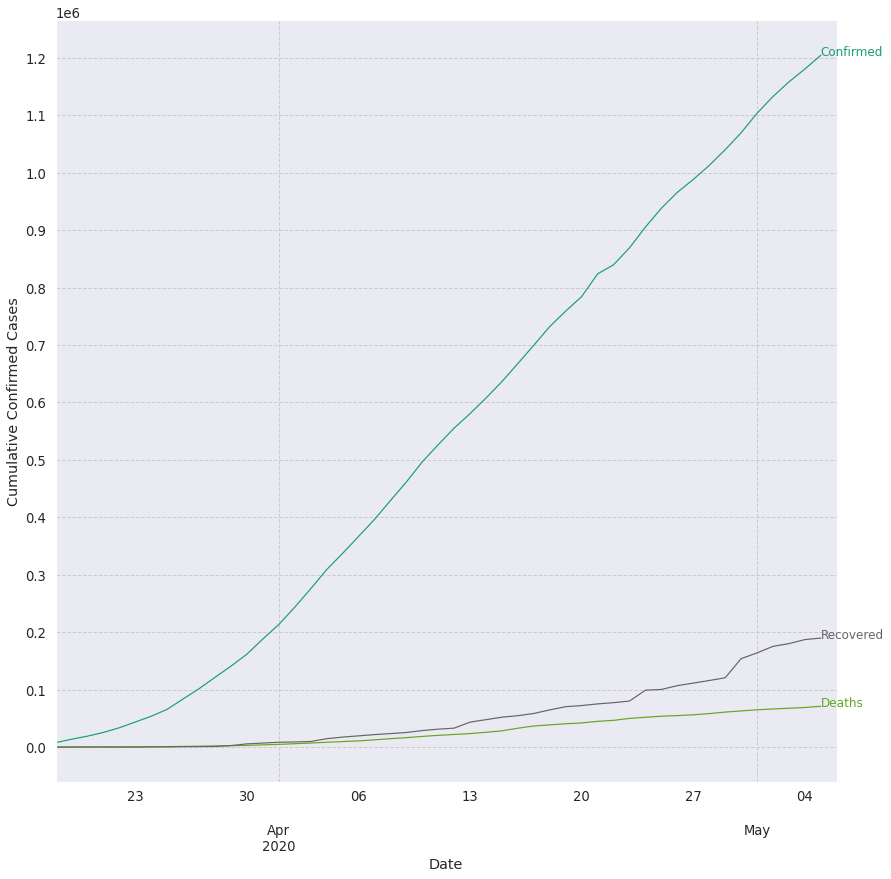

In [19]:
plot_case_growth(country_df.drop("Country_Region", axis=1), tick_interval=100000)

### Cumulative Cases By State

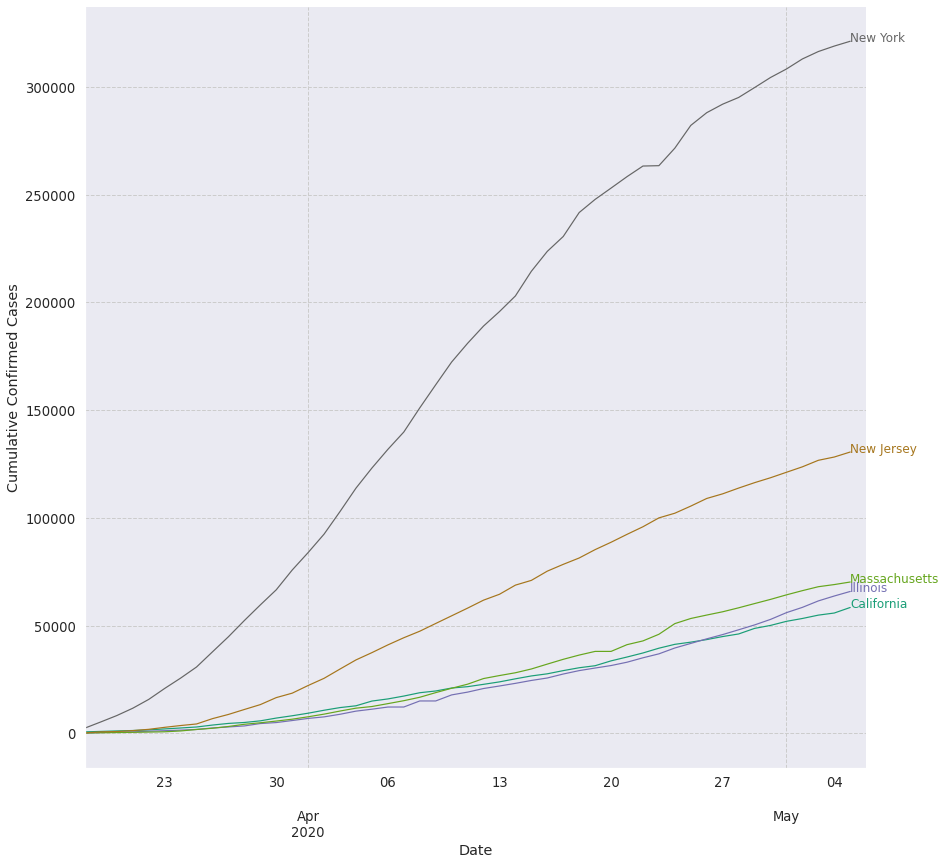

In [20]:
plot_case_growth(cum_state_df)

### Cumulative Cases By State (Normalized Start Date)

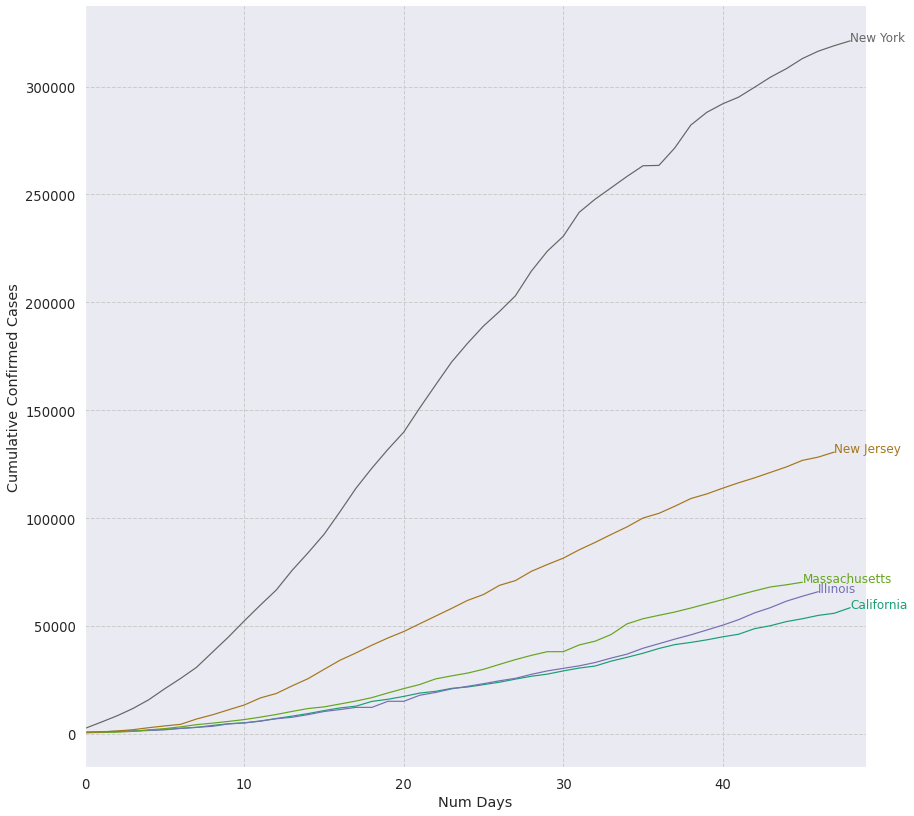

In [21]:
plot_case_growth(build_normalized_state_df(cum_state_df, start_n=500))

### Cumulative Cases By City

In [22]:
if len(cum_city_df.columns) < 49:
    plot_case_growth(cum_city_df)
else:
    print("Too Many Cities to Display")

Too Many Cities to Display


### Cumulative Cases By City (Normalized Start Date)

In [23]:
if len(cum_city_df.columns) < 49:
    plot_case_growth(build_normalized_city_df(cum_city_df, start_n=500))
else:
    print("Too Many Cities to Display")

Too Many Cities to Display


### Daily Growth Rates

         Date Country_Region  Confirmed  D/D Growth (Cases)  D/D Growth (%)
35 2020-04-22             US   839675.0             15889.0        1.928778
36 2020-04-23             US   869170.0             29495.0        3.512669
37 2020-04-24             US   905333.0             36163.0        4.160636
38 2020-04-25             US   938154.0             32821.0        3.625296
39 2020-04-26             US   965783.0             27629.0        2.945039
40 2020-04-27             US   988197.0             22414.0        2.320811
41 2020-04-28             US  1012582.0             24385.0        2.467625
42 2020-04-29             US  1039909.0             27327.0        2.698744
43 2020-04-30             US  1069424.0             29515.0        2.838229
44 2020-05-01             US  1103461.0             34037.0        3.182741
45 2020-05-02             US  1132539.0             29078.0        2.635163
46 2020-05-03             US  1158040.0             25501.0        2.251666
47 2020-05-0

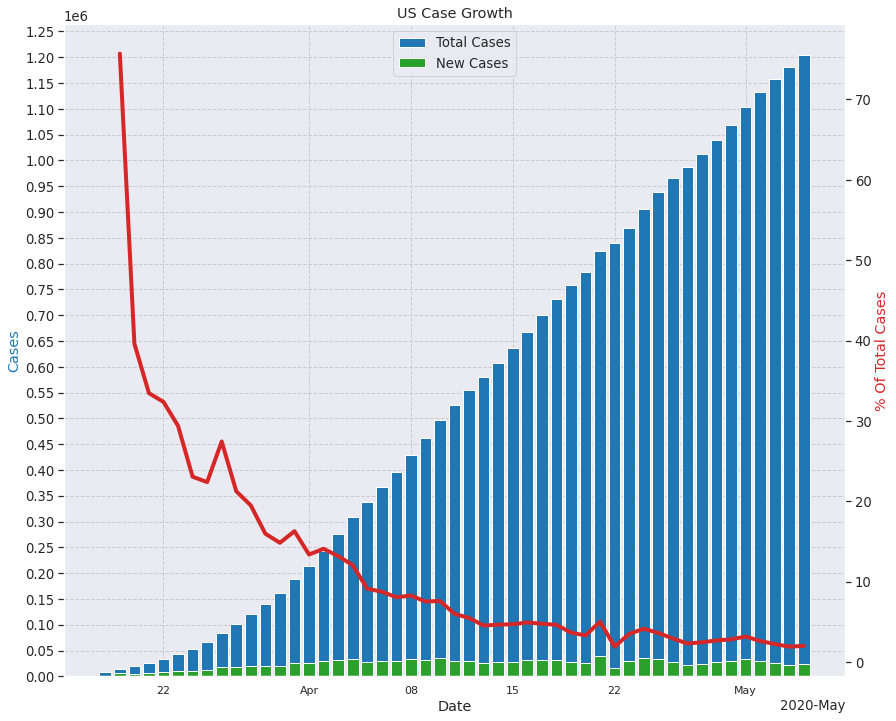

In [24]:
plot_daily_growth(day_over_day_country_df, locale="US", locale_col="Country_Region", tick_interval=50000.0)

           Date Province_State  Confirmed  D/D Growth (Cases)  D/D Growth (%)
2076 2020-04-22       New York   263292.0              4931.0        1.908570
2134 2020-04-23       New York   263460.0               168.0        0.063807
2192 2020-04-24       New York   271590.0              8130.0        3.085857
2250 2020-04-25       New York   282143.0             10553.0        3.885636
2308 2020-04-26       New York   288045.0              5902.0        2.091847
2366 2020-04-27       New York   291996.0              3951.0        1.371661
2424 2020-04-28       New York   295106.0              3110.0        1.065083
2482 2020-04-29       New York   299691.0              4585.0        1.553679
2540 2020-04-30       New York   304372.0              4681.0        1.561942
2598 2020-05-01       New York   308314.0              3942.0        1.295126
2656 2020-05-02       New York   312977.0              4663.0        1.512419
2714 2020-05-03       New York   316415.0              3438.0   

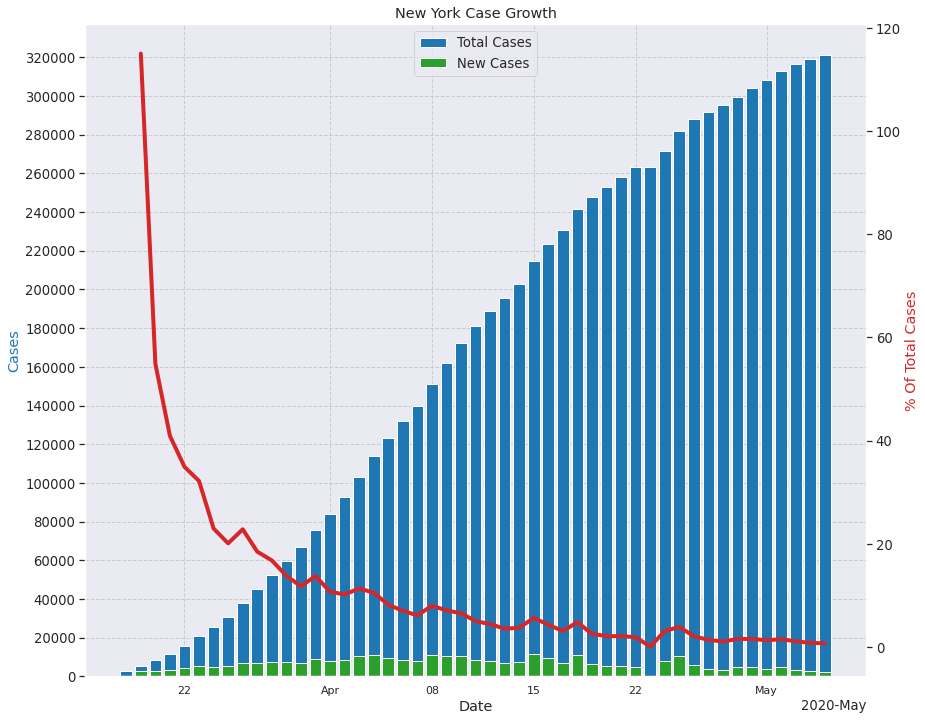

In [25]:
plot_daily_growth(day_over_day_state_df, locale="New York", locale_col="Province_State", tick_interval=20000.0)

            Date           City  Confirmed  D/D Growth (Cases)  D/D Growth (%)
51976 2020-04-22  New York City   147297.0              3107.0        2.154796
53637 2020-04-23  New York City   145855.0             -1442.0       -0.978974
55303 2020-04-24  New York City   150473.0              4618.0        3.166158
56975 2020-04-25  New York City   155113.0              4640.0        3.083610
58651 2020-04-26  New York City   158258.0              3145.0        2.027554
60329 2020-04-27  New York City   160489.0              2231.0        1.409723
62013 2020-04-28  New York City   162338.0              1849.0        1.152104
63701 2020-04-29  New York City   164841.0              2503.0        1.541845
65396 2020-04-30  New York City   167478.0              2637.0        1.599723
67093 2020-05-01  New York City   169690.0              2212.0        1.320770
68794 2020-05-02  New York City   172354.0              2664.0        1.569922
70494 2020-05-03  New York City   174331.0          

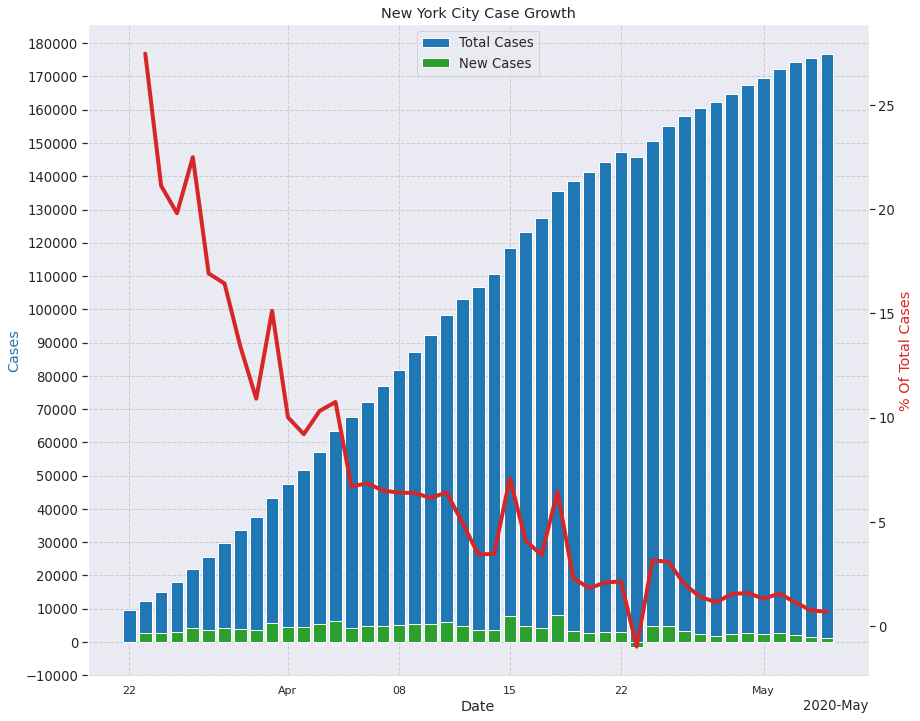

In [26]:
plot_daily_growth(day_over_day_city_df, locale="New York City", locale_col="City", tick_interval=10000.0)